In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6328005456436264257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7958219981
locality {
  bus_id: 1
}
incarnation: 13317188284621431469
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [3]:
"""
Run sample (playing cricket) prediction with joint
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468628

Top classes and probabilities
1.0 41.813675 playing cricket
1.4971534e-09 21.493975 hurling (sport)
3.8430945e-10 20.134102 catching or throwing baseball
1.54923e-10 19.225582 catching or throwing softball
1.1360056e-10 18.915342 hitting baseball
8.801055e-11 18.66011 playing tennis
2.441537e-11 17.377867 playing kickball
1.1531816e-11 16.627764 playing squash or racquetball
6.1319123e-12 15.9961605 shooting goal (soccer)
4.391727e-12 15.662376 hammer throw
2.213431e-12 14.977198 golf putting
1.6307032e-12 14.671666 throwing discus
1.

In [4]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X


def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)


def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
        # plt.show()
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

In [46]:
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma = kwargs.pop('sigma', 1)
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        # may need to change noise instiantiation
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocess as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss, model.classifier are just logits
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        if t % blur_every == 0:
            X = blur_image(X, sigma=sigma)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'max_jitter': 32, 'blur_every': 3, 'num_iterations': 250, 'learning_rate': 1.5, 'num_frames': 25, 'stream_type': 'rgb'}
iteration: 0 11.2093310356


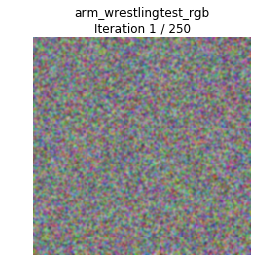

iteration: 1 11.9480109215
iteration: 2 12.6310989857
iteration: 3 13.4243929386
iteration: 4 14.0752379894
iteration: 5 14.7390499115
iteration: 6 15.5966589451
iteration: 7 16.2471630573
iteration: 8 16.8946609497
iteration: 9 17.6459851265
iteration: 10 18.2830269337
iteration: 11 18.9693140984
iteration: 12 19.8120441437
iteration: 13 20.4608530998
iteration: 14 21.1502699852
iteration: 15 21.9805700779
iteration: 16 22.6234130859
iteration: 17 23.2610170841
iteration: 18 24.1120381355
iteration: 19 24.7622590065
iteration: 20 25.4274179935
iteration: 21 26.2462420464
iteration: 22 26.9005739689
iteration: 23 27.5918970108
iteration: 24 28.3850700855


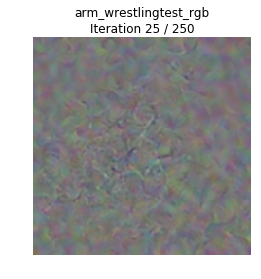

iteration: 25 29.1648619175
iteration: 26 29.8098759651
iteration: 27 30.5896351337
iteration: 28 31.2324669361
iteration: 29 31.8955459595
iteration: 30 32.7002270222
iteration: 31 33.3483929634
iteration: 32 34.0294160843
iteration: 33 34.839564085
iteration: 34 35.4915800095
iteration: 35 36.1830711365
iteration: 36 37.0336179733
iteration: 37 37.6771481037
iteration: 38 38.3435709476
iteration: 39 39.1537389755
iteration: 40 39.8010880947
iteration: 41 40.4742069244
iteration: 42 41.2056341171
iteration: 43 41.8486449718
iteration: 44 42.5338280201
iteration: 45 43.3369910717
iteration: 46 43.9832699299
iteration: 47 44.6181221008
iteration: 48 45.4049091339
iteration: 49 46.0426111221


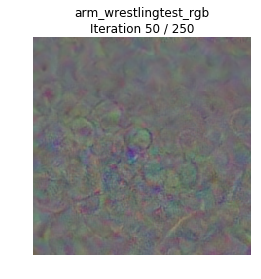

iteration: 50 46.8525159359
iteration: 51 47.660143137
iteration: 52 48.3025939465
iteration: 53 48.9709420204
iteration: 54 49.8077530861
iteration: 55 50.4580140114
iteration: 56 51.1671321392
iteration: 57 52.0067410469
iteration: 58 52.6574990749
iteration: 59 53.3410079479
iteration: 60 54.1359081268
iteration: 61 54.7887499332
iteration: 62 55.4942800999
iteration: 63 56.3506579399
iteration: 64 57.0035569668
iteration: 65 57.6902649403
iteration: 66 58.5495610237
iteration: 67 59.2053179741
iteration: 68 59.8943190575
iteration: 69 60.7202739716
iteration: 70 61.3663260937
iteration: 71 62.0450811386
iteration: 72 62.7769291401
iteration: 73 63.4166629314
iteration: 74 64.1062679291


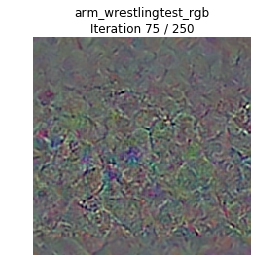

iteration: 75 65.0458869934
iteration: 76 65.6874849796
iteration: 77 66.3316750526
iteration: 78 67.0672030449
iteration: 79 67.7058439255
iteration: 80 68.3800480366
iteration: 81 69.2385749817
iteration: 82 69.889603138
iteration: 83 70.5588960648
iteration: 84 71.4218931198
iteration: 85 72.0694899559
iteration: 86 72.7003519535
iteration: 87 73.4578120708
iteration: 88 74.1016759872
iteration: 89 74.7612230778
iteration: 90 75.5942289829
iteration: 91 76.2286770344
iteration: 92 76.8699939251
iteration: 93 77.7086830139
iteration: 94 78.3694710732
iteration: 95 79.0676641464
iteration: 96 79.9007880688
iteration: 97 80.546626091
iteration: 98 81.1935811043
iteration: 99 82.0450019836


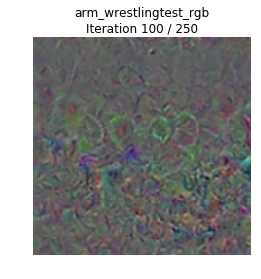

iteration: 100 82.8798680305
iteration: 101 83.585214138
iteration: 102 84.37373209
iteration: 103 85.0173299313
iteration: 104 85.657335043
iteration: 105 86.4538879395
iteration: 106 87.0968780518
iteration: 107 87.7376449108
iteration: 108 88.4924550056
iteration: 109 89.1364400387
iteration: 110 89.8166620731
iteration: 111 90.6080000401
iteration: 112 91.2612850666
iteration: 113 91.9502699375
iteration: 114 92.7402610779
iteration: 115 93.3836300373
iteration: 116 94.0654549599
iteration: 117 94.8537480831
iteration: 118 95.4978020191
iteration: 119 96.1384589672
iteration: 120 96.90052104
iteration: 121 97.5467839241
iteration: 122 98.2340390682
iteration: 123 99.0374379158
iteration: 124 99.6738040447


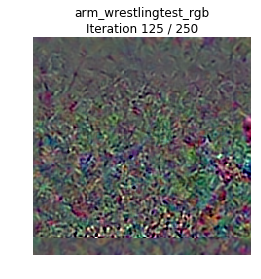

iteration: 125 100.494421959
iteration: 126 101.336641073
iteration: 127 101.988336086
iteration: 128 102.681218147
iteration: 129 103.496840954
iteration: 130 104.163305998
iteration: 131 104.852782011
iteration: 132 105.659565926
iteration: 133 106.308768988
iteration: 134 106.956391096
iteration: 135 107.817363024
iteration: 136 108.466653109
iteration: 137 109.107053995
iteration: 138 109.85313797
iteration: 139 110.499957085
iteration: 140 111.189461946
iteration: 141 111.948665142
iteration: 142 112.592350006
iteration: 143 113.260422945
iteration: 144 114.053467989
iteration: 145 114.693747044
iteration: 146 115.359810114
iteration: 147 116.147295952
iteration: 148 116.780444145
iteration: 149 117.421093941


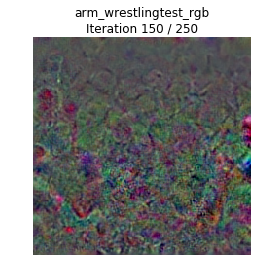

iteration: 150 118.32823801
iteration: 151 118.977514029
iteration: 152 119.624913931
iteration: 153 120.376316071
iteration: 154 121.010175943
iteration: 155 121.643409967
iteration: 156 122.378011942
iteration: 157 123.018204927
iteration: 158 123.664742947
iteration: 159 124.429404974
iteration: 160 125.081321001
iteration: 161 125.715284109
iteration: 162 126.530797005
iteration: 163 127.182723999
iteration: 164 127.827158928
iteration: 165 128.617034912
iteration: 166 129.272454977
iteration: 167 129.961174965
iteration: 168 130.758886099
iteration: 169 131.418214083
iteration: 170 132.134886026
iteration: 171 132.976788044
iteration: 172 133.635066986
iteration: 173 134.318895102
iteration: 174 135.069728136


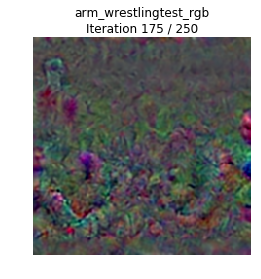

iteration: 175 135.889320135
iteration: 176 136.589831114
iteration: 177 137.430680037
iteration: 178 138.077409029
iteration: 179 138.71420002
iteration: 180 139.509632111
iteration: 181 140.161509037
iteration: 182 140.850023985
iteration: 183 141.692996979
iteration: 184 142.346355915
iteration: 185 143.049958944
iteration: 186 143.90931797
iteration: 187 144.575773001
iteration: 188 145.277034044
iteration: 189 146.138435125
iteration: 190 146.798836946
iteration: 191 147.49103713
iteration: 192 148.34809804
iteration: 193 149.016366005
iteration: 194 149.713539124
iteration: 195 150.509375095
iteration: 196 151.170675039
iteration: 197 151.873764038
iteration: 198 152.732363939
iteration: 199 153.39615202


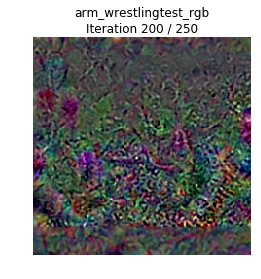

iteration: 200 154.21985507
iteration: 201 155.062433004
iteration: 202 155.716270924
iteration: 203 156.420186996
iteration: 204 157.271239996
iteration: 205 157.935470104
iteration: 206 158.64654398
iteration: 207 159.505343914
iteration: 208 160.162562132
iteration: 209 160.829800129
iteration: 210 161.692760944
iteration: 211 162.356586933
iteration: 212 163.059409142
iteration: 213 163.855665922
iteration: 214 164.50624299
iteration: 215 165.185791969
iteration: 216 166.037464142
iteration: 217 166.699759007
iteration: 218 167.4110291
iteration: 219 168.281084061
iteration: 220 168.937598944
iteration: 221 169.605407
iteration: 222 170.46172905
iteration: 223 171.124234915
iteration: 224 171.82538414


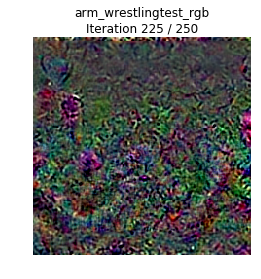

iteration: 225 172.671509027
iteration: 226 173.316779137
iteration: 227 173.962006092
iteration: 228 174.938740969
iteration: 229 175.601138115
iteration: 230 176.294606924
iteration: 231 177.170642138
iteration: 232 177.833683968
iteration: 233 178.529374123
iteration: 234 179.371074915
iteration: 235 180.045458078
iteration: 236 180.756428003
iteration: 237 181.628421068
iteration: 238 182.291954994
iteration: 239 182.991291046
iteration: 240 183.844324112
iteration: 241 184.510143995
iteration: 242 185.223400116
iteration: 243 186.097383976
iteration: 244 186.764827013
iteration: 245 187.462387085
iteration: 246 188.299135923
iteration: 247 188.965371132
iteration: 248 189.682555914
iteration: 249 190.550043106
file_name experiments_rgb/arm_wrestlingtest/arm_wrestlingtest_rgb{}.png


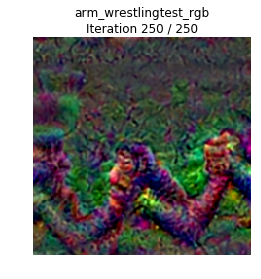

In [6]:
"""
Run RGB visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(rgb_input)
target = 6
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name + "test", 
                                   stream_type='rgb', num_frames=25, num_iterations=250, learning_rate=1.5, 
                                   blur_every=3, max_jitter=32)

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder_1:0", shape=(1, ?, 224, 224, 2), dtype=float32)
juggling soccer ball
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
params {'blur_every': 10, 'num_frames': 25, 'num_iterations': 1000, 'learning_rate': 1.5, 'stream_type': 'flow', 'max_jitter': 32, 'sigma': 0.5, 'l2_reg': 0.01}
iteration: 0 2.24673199654


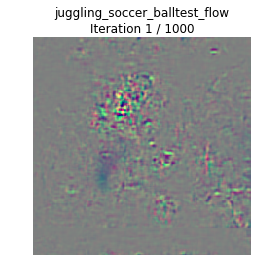

iteration: 1 4.1413769722
iteration: 2 5.9106400013
iteration: 3 7.71331310272
iteration: 4 9.59364104271
iteration: 5 11.4667429924
iteration: 6 13.3416678905
iteration: 7 15.1634569168
iteration: 8 16.9517729282
iteration: 9 18.7771348953
iteration: 10 20.8941440582
iteration: 11 22.7206089497
iteration: 12 24.5749750137
iteration: 13 26.4416239262
iteration: 14 28.2912321091
iteration: 15 30.1347239017
iteration: 16 31.9906699657
iteration: 17 33.8363499641
iteration: 18 35.7040770054
iteration: 19 37.5283610821
iteration: 20 39.5431818962
iteration: 21 41.350632906
iteration: 22 43.1902549267
iteration: 23 45.0624539852
iteration: 24 46.9084188938


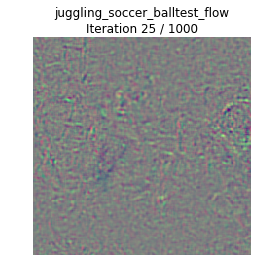

iteration: 25 48.9695110321
iteration: 26 50.8093030453
iteration: 27 52.6644749641
iteration: 28 54.5157659054
iteration: 29 56.3717570305
iteration: 30 58.4436080456
iteration: 31 60.2670490742
iteration: 32 62.1425418854
iteration: 33 63.986123085
iteration: 34 65.8443939686
iteration: 35 67.6822240353
iteration: 36 69.55707407
iteration: 37 71.4182569981
iteration: 38 73.2611320019
iteration: 39 75.1062440872
iteration: 40 77.1358940601
iteration: 41 78.9456179142
iteration: 42 80.7956740856
iteration: 43 82.6276500225
iteration: 44 84.446655035
iteration: 45 86.2981500626
iteration: 46 88.0929529667
iteration: 47 89.9108290672
iteration: 48 91.8565320969
iteration: 49 93.7147490978


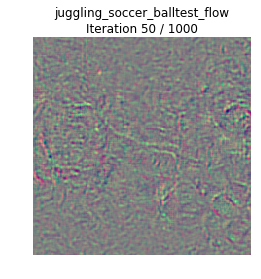

iteration: 50 95.9228179455
iteration: 51 97.7253329754
iteration: 52 99.5428049564
iteration: 53 101.333816051
iteration: 54 103.177005053
iteration: 55 104.972668886
iteration: 56 106.822936058
iteration: 57 108.668461084
iteration: 58 110.516937017
iteration: 59 112.315398932
iteration: 60 114.337785959
iteration: 61 116.157552004
iteration: 62 118.019335032
iteration: 63 119.869776964
iteration: 64 121.729152918
iteration: 65 123.531100988
iteration: 66 125.397167921
iteration: 67 127.25160408
iteration: 68 129.117641926
iteration: 69 130.976253986
iteration: 70 132.950622082
iteration: 71 134.751262903
iteration: 72 136.602612972
iteration: 73 138.471405983
iteration: 74 140.331360102


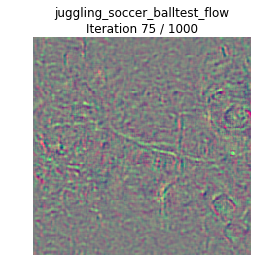

iteration: 75 142.320210934
iteration: 76 144.148266077
iteration: 77 146.055728912
iteration: 78 147.856220961
iteration: 79 149.711078882
iteration: 80 151.790885925
iteration: 81 153.604691982
iteration: 82 155.45274806
iteration: 83 157.324266911
iteration: 84 159.15219903
iteration: 85 161.006880999
iteration: 86 162.882492065
iteration: 87 164.733853102
iteration: 88 166.569165945
iteration: 89 168.371994972
iteration: 90 170.413878918
iteration: 91 172.236569881
iteration: 92 174.089365005
iteration: 93 175.926158905
iteration: 94 177.782402992
iteration: 95 179.638011932
iteration: 96 181.489135981
iteration: 97 183.338174105
iteration: 98 185.199284077
iteration: 99 187.055242062


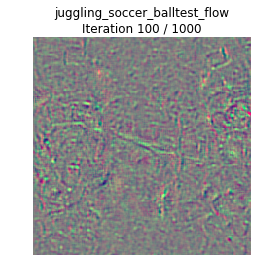

iteration: 100 189.208580017
iteration: 101 191.018385887
iteration: 102 192.880531073
iteration: 103 194.700150013
iteration: 104 196.531169891
iteration: 105 198.369222879
iteration: 106 200.208223104
iteration: 107 202.076493979
iteration: 108 203.908461094
iteration: 109 205.753782034
iteration: 110 207.827842951
iteration: 111 209.640171051
iteration: 112 211.494368076
iteration: 113 213.298216105
iteration: 114 215.126601934
iteration: 115 216.972861052
iteration: 116 218.834932089
iteration: 117 220.706535101
iteration: 118 222.552563906
iteration: 119 224.414870977
iteration: 120 226.426409006
iteration: 121 228.241029978
iteration: 122 230.104146957
iteration: 123 231.965051889
iteration: 124 233.827620983


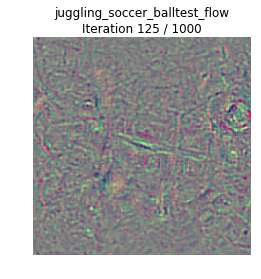

iteration: 125 235.828281879
iteration: 126 237.687161922
iteration: 127 239.511939049
iteration: 128 241.390182972
iteration: 129 243.257003069
iteration: 130 245.307486057
iteration: 131 247.128066063
iteration: 132 248.957834005
iteration: 133 250.763451099
iteration: 134 252.636214972
iteration: 135 254.493676901
iteration: 136 256.366194963
iteration: 137 258.217706919
iteration: 138 260.054007053
iteration: 139 261.930983067
iteration: 140 264.035418987
iteration: 141 265.88397789
iteration: 142 267.720438957
iteration: 143 269.575536013
iteration: 144 271.4222579
iteration: 145 273.262149096
iteration: 146 275.125192881
iteration: 147 276.965142965
iteration: 148 278.797342062
iteration: 149 280.648787975


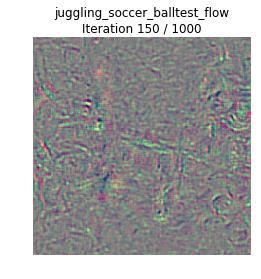

iteration: 150 282.905598879
iteration: 151 284.723874092
iteration: 152 286.601178885
iteration: 153 288.485287905
iteration: 154 290.333971024
iteration: 155 292.185131073
iteration: 156 294.037093878
iteration: 157 295.876637936
iteration: 158 297.771483898
iteration: 159 299.590938091
iteration: 160 301.64043498
iteration: 161 303.422596931
iteration: 162 305.205523014
iteration: 163 306.990995884
iteration: 164 308.814718008
iteration: 165 310.679446936
iteration: 166 312.515266895
iteration: 167 314.352092981
iteration: 168 316.16314292
iteration: 169 317.949105978
iteration: 170 319.97815609
iteration: 171 321.788177967
iteration: 172 323.647101879
iteration: 173 325.494560957
iteration: 174 327.34403491


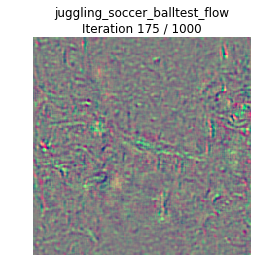

iteration: 175 329.356767893
iteration: 176 331.174591064
iteration: 177 333.046242952
iteration: 178 334.890208006
iteration: 179 336.732944965
iteration: 180 338.784874916
iteration: 181 340.606198072
iteration: 182 342.457784891
iteration: 183 344.252569914
iteration: 184 346.099308014
iteration: 185 347.910485029
iteration: 186 349.754826069
iteration: 187 351.613404989
iteration: 188 353.400161982
iteration: 189 355.199913025
iteration: 190 357.214215994
iteration: 191 359.038438082
iteration: 192 360.909261942
iteration: 193 362.741966009
iteration: 194 364.541797876
iteration: 195 366.378072023
iteration: 196 368.190927982
iteration: 197 370.041923046
iteration: 198 371.91898489
iteration: 199 373.778604031


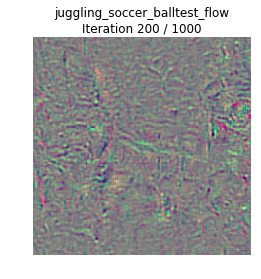

iteration: 200 375.96387291
iteration: 201 377.789032936
iteration: 202 379.638978004
iteration: 203 381.430152893
iteration: 204 383.28967905
iteration: 205 385.130408049
iteration: 206 386.969656944
iteration: 207 388.778810024
iteration: 208 390.65604496
iteration: 209 392.495351076
iteration: 210 394.487793922
iteration: 211 396.283077955
iteration: 212 398.142539978
iteration: 213 400.024861097
iteration: 214 401.866694927
iteration: 215 403.664441109
iteration: 216 405.529004097
iteration: 217 407.36778903
iteration: 218 409.189286947
iteration: 219 411.033274889
iteration: 220 413.051248074
iteration: 221 414.854294062
iteration: 222 416.702043056
iteration: 223 418.572263956
iteration: 224 420.421974897


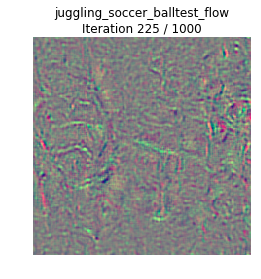

iteration: 225 422.431701899
iteration: 226 424.297520876
iteration: 227 426.14447403
iteration: 228 428.011260986
iteration: 229 429.855555058
iteration: 230 431.882745981
iteration: 231 433.6819489
iteration: 232 435.523870945
iteration: 233 437.351082087
iteration: 234 439.194421053
iteration: 235 441.032799959
iteration: 236 442.855614901
iteration: 237 444.734011889
iteration: 238 446.5955019
iteration: 239 448.402312994
iteration: 240 450.393863916
iteration: 241 452.198580027
iteration: 242 454.050244093
iteration: 243 455.88011694
iteration: 244 457.735737085
iteration: 245 459.565284967
iteration: 246 461.358274937
iteration: 247 463.19005394
iteration: 248 465.041778088
iteration: 249 466.897037983


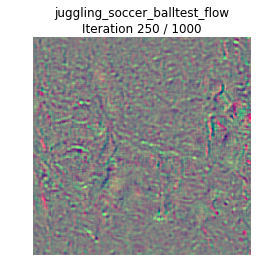

iteration: 250 469.141704082
iteration: 251 470.958798885
iteration: 252 472.813081026
iteration: 253 474.655380964
iteration: 254 476.540456057
iteration: 255 478.414017916
iteration: 256 480.230768919
iteration: 257 482.052105904
iteration: 258 483.844264984
iteration: 259 485.643970966
iteration: 260 487.711152077
iteration: 261 489.521194935
iteration: 262 491.388173103
iteration: 263 493.224585056
iteration: 264 495.072918892
iteration: 265 496.919833899
iteration: 266 498.778430939
iteration: 267 500.591424942
iteration: 268 502.433135986
iteration: 269 504.307205915
iteration: 270 506.36251092
iteration: 271 508.177659035
iteration: 272 510.003900051
iteration: 273 511.846054077
iteration: 274 513.719646931


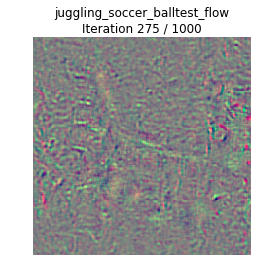

iteration: 275 515.716403008
iteration: 276 517.607547998
iteration: 277 519.471395016
iteration: 278 521.336071014
iteration: 279 523.181216955
iteration: 280 525.21844101
iteration: 281 527.029524088
iteration: 282 528.88309288
iteration: 283 530.751213074
iteration: 284 532.577796936
iteration: 285 534.42324996
iteration: 286 536.257615089
iteration: 287 538.049046993
iteration: 288 539.850477934
iteration: 289 541.791320086
iteration: 290 543.813415051
iteration: 291 545.634995937
iteration: 292 547.518002033
iteration: 293 549.341234922
iteration: 294 551.190021992
iteration: 295 553.061393023
iteration: 296 554.914573908
iteration: 297 556.774463892
iteration: 298 558.646046877
iteration: 299 560.474411964


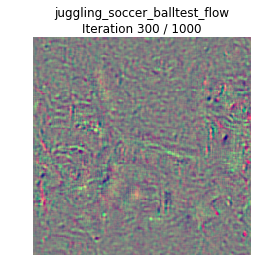

iteration: 300 562.736325979
iteration: 301 564.550751925
iteration: 302 566.409285069
iteration: 303 568.208913088
iteration: 304 570.054033041
iteration: 305 571.863776922
iteration: 306 573.699357986
iteration: 307 575.558820963
iteration: 308 577.441441059
iteration: 309 579.298950911
iteration: 310 581.316593885
iteration: 311 583.130511999
iteration: 312 585.0094769
iteration: 313 586.85451889
iteration: 314 588.698903084
iteration: 315 590.554090023
iteration: 316 592.406508923
iteration: 317 594.254667997
iteration: 318 596.063818932
iteration: 319 597.927910089
iteration: 320 599.995127916
iteration: 321 601.812293053
iteration: 322 603.700120926
iteration: 323 605.554228067
iteration: 324 607.419926882


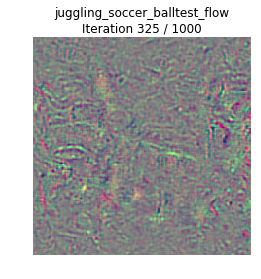

iteration: 325 609.413968086
iteration: 326 611.279635906
iteration: 327 613.094188929
iteration: 328 614.960599899
iteration: 329 616.823559046
iteration: 330 618.782221079
iteration: 331 620.574771881
iteration: 332 622.448292017
iteration: 333 624.329567909
iteration: 334 626.197555065
iteration: 335 628.019393921
iteration: 336 629.814541101
iteration: 337 631.747282982
iteration: 338 633.623712063
iteration: 339 635.487210989
iteration: 340 637.582105875
iteration: 341 639.411454916
iteration: 342 641.363255024
iteration: 343 643.23094511
iteration: 344 645.100601912
iteration: 345 647.00784111
iteration: 346 648.814119101
iteration: 347 650.678867102
iteration: 348 652.537362099
iteration: 349 654.385485888


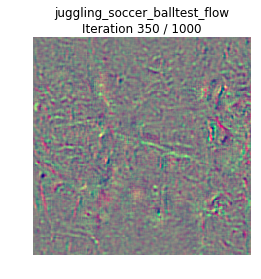

iteration: 350 656.560295105
iteration: 351 658.383435965
iteration: 352 660.249825001
iteration: 353 662.118917942
iteration: 354 663.980061054
iteration: 355 665.838593006
iteration: 356 667.678545952
iteration: 357 669.538907051
iteration: 358 671.405471087
iteration: 359 673.286324978
iteration: 360 675.341721058
iteration: 361 677.146404982
iteration: 362 678.999722958
iteration: 363 680.850015879
iteration: 364 682.715302944
iteration: 365 684.590291977
iteration: 366 686.451121092
iteration: 367 688.294737101
iteration: 368 690.150451899
iteration: 369 692.011430979
iteration: 370 694.000699043
iteration: 371 695.793514967
iteration: 372 697.599783897
iteration: 373 699.442975044
iteration: 374 701.298374891


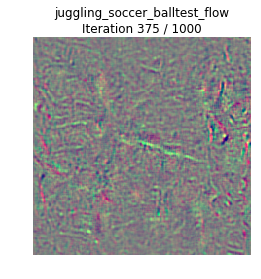

iteration: 375 703.279767036
iteration: 376 705.162163019
iteration: 377 707.032752037
iteration: 378 708.891460896
iteration: 379 710.771571875
iteration: 380 712.7543571
iteration: 381 714.551528931
iteration: 382 716.387192965
iteration: 383 718.261101961
iteration: 384 720.132167101
iteration: 385 721.973115921
iteration: 386 723.843833923
iteration: 387 725.715284109
iteration: 388 727.582551003
iteration: 389 729.450416088
iteration: 390 731.519046068
iteration: 391 733.342281103
iteration: 392 735.188531876
iteration: 393 737.060962915
iteration: 394 738.91740489
iteration: 395 740.758858919
iteration: 396 742.634047985
iteration: 397 744.485342026
iteration: 398 746.35364604
iteration: 399 748.20183897


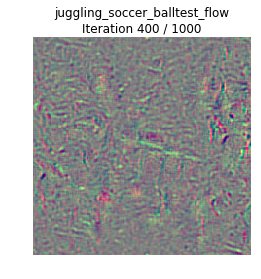

iteration: 400 750.398066044
iteration: 401 752.220710039
iteration: 402 754.08170104
iteration: 403 755.946706057
iteration: 404 757.771445036
iteration: 405 759.635298967
iteration: 406 761.492383957
iteration: 407 763.349008083
iteration: 408 765.214807987
iteration: 409 767.071300983
iteration: 410 769.142163992
iteration: 411 770.962239981
iteration: 412 772.840598106
iteration: 413 774.712236881
iteration: 414 776.556332111
iteration: 415 778.410908937
iteration: 416 780.232315063
iteration: 417 782.084917068
iteration: 418 783.87686801
iteration: 419 785.69028306
iteration: 420 787.766154051
iteration: 421 789.590940952
iteration: 422 791.468308926
iteration: 423 793.305984974
iteration: 424 795.105690956


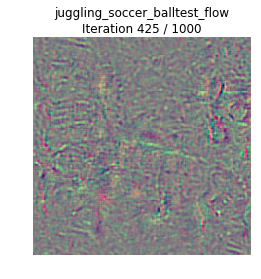

iteration: 425 797.041223049
iteration: 426 798.824872017
iteration: 427 800.622745037
iteration: 428 802.444633007
iteration: 429 804.316555977
iteration: 430 806.327104092
iteration: 431 808.133410931
iteration: 432 809.99615407
iteration: 433 811.843255997
iteration: 434 813.686800957
iteration: 435 815.545291901
iteration: 436 817.400269032
iteration: 437 819.264153004
iteration: 438 821.127526045
iteration: 439 823.012633085
iteration: 440 825.109031916
iteration: 441 826.946033955
iteration: 442 828.810308933
iteration: 443 830.681411982
iteration: 444 832.543104887
iteration: 445 834.369415045
iteration: 446 836.233648062
iteration: 447 838.096559048
iteration: 448 839.948745012
iteration: 449 841.802911043


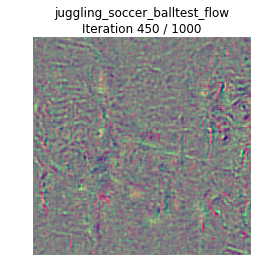

iteration: 450 843.932395935
iteration: 451 845.748722076
iteration: 452 847.584825993
iteration: 453 849.455075979
iteration: 454 851.31606698
iteration: 455 853.173631907
iteration: 456 855.040875912
iteration: 457 856.882678986
iteration: 458 858.742161989
iteration: 459 860.592890978
iteration: 460 862.613250971
iteration: 461 864.429934025
iteration: 462 866.224771976
iteration: 463 868.051001072
iteration: 464 869.915036917
iteration: 465 871.791088104
iteration: 466 873.670149088
iteration: 467 875.511384964
iteration: 468 877.377019882
iteration: 469 879.213500977
iteration: 470 881.311105013
iteration: 471 883.145071983
iteration: 472 885.015758038
iteration: 473 886.828923941
iteration: 474 888.670850992


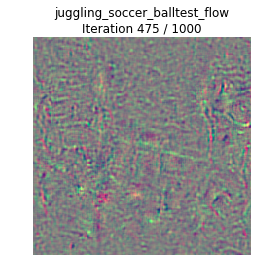

iteration: 475 890.592359066
iteration: 476 892.410341978
iteration: 477 894.192974091
iteration: 478 895.98398304
iteration: 479 897.783878088
iteration: 480 899.805701971
iteration: 481 901.584758043
iteration: 482 903.383111954
iteration: 483 905.250087976
iteration: 484 907.061212063
iteration: 485 908.893920898
iteration: 486 910.743479013
iteration: 487 912.614464045
iteration: 488 914.488028049
iteration: 489 916.368295908
iteration: 490 918.434452057
iteration: 491 920.243856907
iteration: 492 922.121946096
iteration: 493 923.967504025
iteration: 494 925.852309942
iteration: 495 927.733375072
iteration: 496 929.587229967
iteration: 497 931.374193907
iteration: 498 933.184520006
iteration: 499 935.058743954


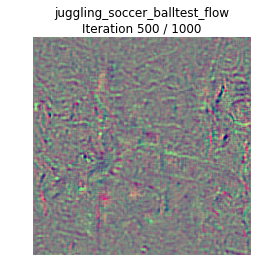

iteration: 500 937.266316891
iteration: 501 939.092977047
iteration: 502 940.962045908
iteration: 503 942.758606911
iteration: 504 944.615360022
iteration: 505 946.448363066
iteration: 506 948.267343044
iteration: 507 950.088567019
iteration: 508 951.96983099
iteration: 509 953.842097998
iteration: 510 955.919290066
iteration: 511 957.747881889
iteration: 512 959.715650082
iteration: 513 961.583098888
iteration: 514 963.463722944
iteration: 515 965.322736025
iteration: 516 967.192425013
iteration: 517 969.069107056
iteration: 518 970.942609072
iteration: 519 972.816097021
iteration: 520 974.757653952
iteration: 521 976.574713945
iteration: 522 978.382515907
iteration: 523 980.264082909
iteration: 524 982.128901005


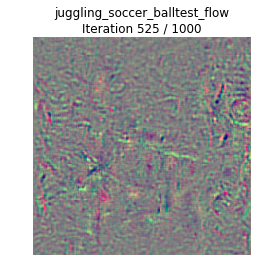

iteration: 525 984.157907963
iteration: 526 986.025407076
iteration: 527 987.836495876
iteration: 528 989.71056509
iteration: 529 991.555911064
iteration: 530 993.662215948
iteration: 531 995.491662979
iteration: 532 997.35560298
iteration: 533 999.229530096
iteration: 534 1001.08666205
iteration: 535 1002.95117188
iteration: 536 1004.8096981
iteration: 537 1006.61351705
iteration: 538 1008.48193693
iteration: 539 1010.30673003
iteration: 540 1012.3945241
iteration: 541 1014.2042141
iteration: 542 1016.07324505
iteration: 543 1017.95035195
iteration: 544 1019.817873
iteration: 545 1021.66124701
iteration: 546 1023.51677203
iteration: 547 1025.36745
iteration: 548 1027.23203993
iteration: 549 1029.10401011


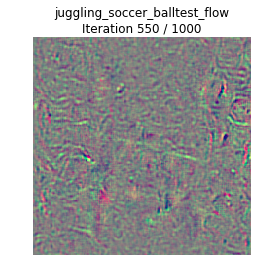

iteration: 550 1031.22095895
iteration: 551 1033.00559998
iteration: 552 1034.80122805
iteration: 553 1036.62852693
iteration: 554 1038.49220705
iteration: 555 1040.344414
iteration: 556 1042.17482209
iteration: 557 1043.97731709
iteration: 558 1045.83531189
iteration: 559 1047.6861949
iteration: 560 1049.73223495
iteration: 561 1051.546875
iteration: 562 1053.41562104
iteration: 563 1055.24042797
iteration: 564 1057.12555599
iteration: 565 1058.994946
iteration: 566 1060.89767289
iteration: 567 1062.76895308
iteration: 568 1064.64734602
iteration: 569 1066.52889895
iteration: 570 1068.57421708
iteration: 571 1070.38729692
iteration: 572 1072.24148893
iteration: 573 1074.05512094
iteration: 574 1075.9388659


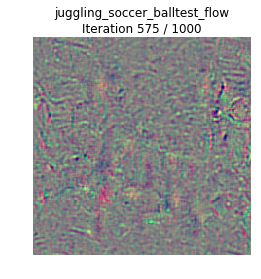

iteration: 575 1077.98210502
iteration: 576 1079.83058
iteration: 577 1081.72122788
iteration: 578 1083.63118911
iteration: 579 1085.50668502
iteration: 580 1087.56762099
iteration: 581 1089.39357305
iteration: 582 1091.24332595
iteration: 583 1093.10698795
iteration: 584 1094.96195889
iteration: 585 1096.849123
iteration: 586 1098.652004
iteration: 587 1100.4622829
iteration: 588 1102.35673499
iteration: 589 1104.19523501
iteration: 590 1106.25759792
iteration: 591 1108.08560801
iteration: 592 1109.94124508
iteration: 593 1111.81478906
iteration: 594 1113.63613605
iteration: 595 1115.4955709
iteration: 596 1117.335078
iteration: 597 1119.21829605
iteration: 598 1121.08712006
iteration: 599 1122.92636991


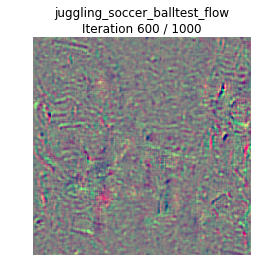

iteration: 600 1125.00037694
iteration: 601 1126.80370402
iteration: 602 1128.657197
iteration: 603 1130.45569706
iteration: 604 1132.26694393
iteration: 605 1134.14742804
iteration: 606 1136.0016911
iteration: 607 1137.86347103
iteration: 608 1139.71184587
iteration: 609 1141.56643009
iteration: 610 1143.64833307
iteration: 611 1145.45254803
iteration: 612 1147.27686596
iteration: 613 1149.22504997
iteration: 614 1151.06968188
iteration: 615 1152.88781404
iteration: 616 1154.73508501
iteration: 617 1156.60121298
iteration: 618 1158.4426949
iteration: 619 1160.27593708
iteration: 620 1162.29724908
iteration: 621 1164.09708309
iteration: 622 1165.94794989
iteration: 623 1167.803339
iteration: 624 1169.67438388


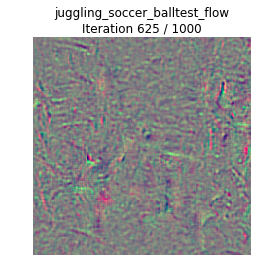

iteration: 625 1171.62601209
iteration: 626 1173.49271393
iteration: 627 1175.37732506
iteration: 628 1177.23065591
iteration: 629 1179.11594105
iteration: 630 1181.14033699
iteration: 631 1182.95525193
iteration: 632 1184.80692792
iteration: 633 1186.61356997
iteration: 634 1188.44511509
iteration: 635 1190.30036592
iteration: 636 1192.1707139
iteration: 637 1194.12862396
iteration: 638 1195.96815395
iteration: 639 1197.82606697
iteration: 640 1199.91721201
iteration: 641 1201.75408888
iteration: 642 1203.60199499
iteration: 643 1205.52472711
iteration: 644 1207.39540601
iteration: 645 1209.26951694
iteration: 646 1211.15968299
iteration: 647 1213.04105806
iteration: 648 1214.91347504
iteration: 649 1216.73175097


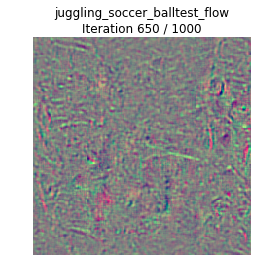

iteration: 650 1218.97800088
iteration: 651 1220.80854702
iteration: 652 1222.67572498
iteration: 653 1224.55037498
iteration: 654 1226.40900588
iteration: 655 1228.29604101
iteration: 656 1230.16013002
iteration: 657 1232.02197289
iteration: 658 1233.88361311
iteration: 659 1235.7579689
iteration: 660 1237.81726193
iteration: 661 1239.64686489
iteration: 662 1241.52377295
iteration: 663 1243.39293909
iteration: 664 1245.25177693
iteration: 665 1247.11048794
iteration: 666 1248.94465709
iteration: 667 1250.79782796
iteration: 668 1252.63161302
iteration: 669 1254.4484899
iteration: 670 1256.52879691
iteration: 671 1258.35084605
iteration: 672 1260.21572089
iteration: 673 1262.04951596
iteration: 674 1263.90456104


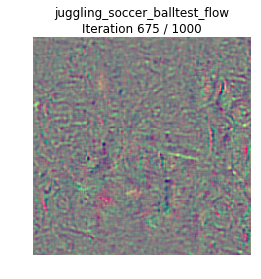

iteration: 675 1265.90048599
iteration: 676 1267.73578405
iteration: 677 1269.62618589
iteration: 678 1271.49572206
iteration: 679 1273.35815001
iteration: 680 1275.38519597
iteration: 681 1277.20149803
iteration: 682 1279.07225704
iteration: 683 1280.94110203
iteration: 684 1282.82975793
iteration: 685 1284.69355106
iteration: 686 1286.57848096
iteration: 687 1288.44950104
iteration: 688 1290.29801011
iteration: 689 1292.13681602
iteration: 690 1294.23446202
iteration: 691 1296.06645799
iteration: 692 1297.93694711
iteration: 693 1299.82134604
iteration: 694 1301.69532204
iteration: 695 1303.52333903
iteration: 696 1305.39896703
iteration: 697 1307.22524309
iteration: 698 1309.08113098
iteration: 699 1310.9515121


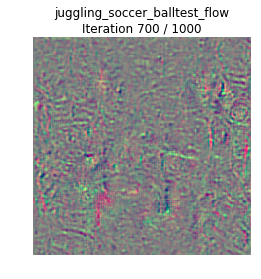

iteration: 700 1313.208323
iteration: 701 1315.04900599
iteration: 702 1316.92396593
iteration: 703 1318.79999804
iteration: 704 1320.65203309
iteration: 705 1322.48158288
iteration: 706 1324.36566305
iteration: 707 1326.24541807
iteration: 708 1328.13191891
iteration: 709 1329.98521304
iteration: 710 1332.07586002
iteration: 711 1333.89600801
iteration: 712 1335.77415109
iteration: 713 1337.67306209
iteration: 714 1339.53641701
iteration: 715 1341.36789894
iteration: 716 1343.21563697
iteration: 717 1345.08045292
iteration: 718 1346.9080689
iteration: 719 1348.75535607
iteration: 720 1350.78430009
iteration: 721 1352.5899961
iteration: 722 1354.41943502
iteration: 723 1356.25441909
iteration: 724 1358.1141789


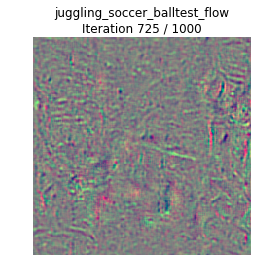

iteration: 725 1360.14259005
iteration: 726 1362.03917003
iteration: 727 1363.92624593
iteration: 728 1365.77919197
iteration: 729 1367.6288259
iteration: 730 1369.69734597
iteration: 731 1371.52946806
iteration: 732 1373.41164994
iteration: 733 1375.27442694
iteration: 734 1377.15384507
iteration: 735 1379.01460505
iteration: 736 1380.91173196
iteration: 737 1382.81040001
iteration: 738 1384.69091702
iteration: 739 1386.5729301
iteration: 740 1388.67058611
iteration: 741 1390.51435709
iteration: 742 1392.39190102
iteration: 743 1394.27540898
iteration: 744 1396.16046596
iteration: 745 1398.00098109
iteration: 746 1399.88194489
iteration: 747 1401.73318291
iteration: 748 1403.60946393
iteration: 749 1405.54081488


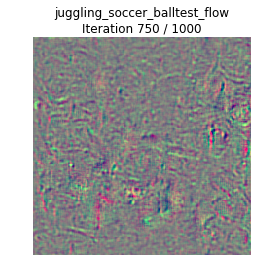

iteration: 750 1407.79320097
iteration: 751 1409.73436189
iteration: 752 1411.61482692
iteration: 753 1413.472018
iteration: 754 1415.28558803
iteration: 755 1417.14652395
iteration: 756 1419.00606704
iteration: 757 1420.81906796
iteration: 758 1422.64124203
iteration: 759 1424.46468496
iteration: 760 1426.59242892
iteration: 761 1428.42810702
iteration: 762 1430.30008388
iteration: 763 1432.12966704
iteration: 764 1434.00493407
iteration: 765 1435.90189195
iteration: 766 1437.76415396
iteration: 767 1439.61962199
iteration: 768 1441.47926307
iteration: 769 1443.33068991
iteration: 770 1445.4134481
iteration: 771 1447.22076488
iteration: 772 1449.03153205
iteration: 773 1450.83913302
iteration: 774 1452.66322899


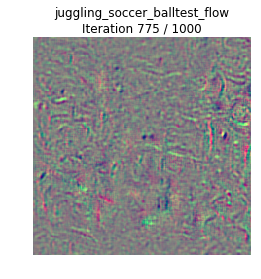

iteration: 775 1454.70792103
iteration: 776 1456.57786393
iteration: 777 1458.46097803
iteration: 778 1460.32688498
iteration: 779 1462.16711092
iteration: 780 1464.212677
iteration: 781 1466.03268504
iteration: 782 1467.912848
iteration: 783 1469.7688849
iteration: 784 1471.63863802
iteration: 785 1473.51988411
iteration: 786 1475.41466904
iteration: 787 1477.28121305
iteration: 788 1479.10697293
iteration: 789 1480.99115801
iteration: 790 1483.08093309
iteration: 791 1484.92329192
iteration: 792 1486.80413198
iteration: 793 1488.70218992
iteration: 794 1490.57720304
iteration: 795 1492.46618509
iteration: 796 1494.33728909
iteration: 797 1496.20237994
iteration: 798 1498.10141397
iteration: 799 1499.970119


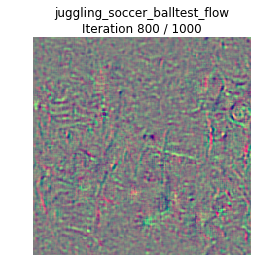

iteration: 800 1502.23659205
iteration: 801 1504.07034111
iteration: 802 1505.93817711
iteration: 803 1507.81930208
iteration: 804 1509.67972708
iteration: 805 1511.58059597
iteration: 806 1513.46047091
iteration: 807 1515.346457
iteration: 808 1517.23526788
iteration: 809 1519.06834006
iteration: 810 1521.136693
iteration: 811 1522.974123
iteration: 812 1524.8665731
iteration: 813 1526.73314905
iteration: 814 1528.64787197
iteration: 815 1530.48844004
iteration: 816 1532.28980994
iteration: 817 1534.09940195
iteration: 818 1535.94948697
iteration: 819 1537.86574197
iteration: 820 1539.95899701
iteration: 821 1541.79598403
iteration: 822 1543.67861009
iteration: 823 1545.49616909
iteration: 824 1547.32445788


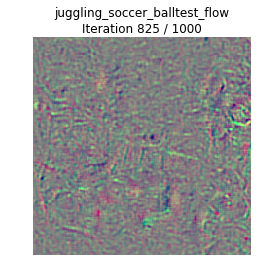

iteration: 825 1549.34383893
iteration: 826 1551.15580392
iteration: 827 1553.02289009
iteration: 828 1554.86099911
iteration: 829 1556.76154089
iteration: 830 1558.81967092
iteration: 831 1560.66155291
iteration: 832 1562.52185988
iteration: 833 1564.39696407
iteration: 834 1566.22571111
iteration: 835 1568.09637094
iteration: 836 1569.9836061
iteration: 837 1571.87436509
iteration: 838 1573.72262001
iteration: 839 1575.55885196
iteration: 840 1577.61610389
iteration: 841 1579.43023896
iteration: 842 1581.28164101
iteration: 843 1583.1686511
iteration: 844 1585.05852103
iteration: 845 1586.92003298
iteration: 846 1588.80679703
iteration: 847 1590.65631509
iteration: 848 1592.4878881
iteration: 849 1594.3855381


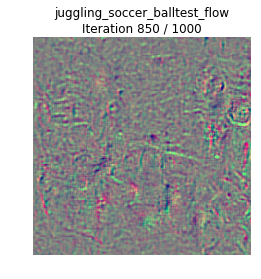

iteration: 850 1596.65549302
iteration: 851 1598.48042297
iteration: 852 1600.30192995
iteration: 853 1602.21239805
iteration: 854 1604.097615
iteration: 855 1605.98033905
iteration: 856 1607.86507201
iteration: 857 1609.74496603
iteration: 858 1611.66225505
iteration: 859 1613.52722907
iteration: 860 1615.63174701
iteration: 861 1617.47032499
iteration: 862 1619.34771395
iteration: 863 1621.24059606
iteration: 864 1623.13278604
iteration: 865 1625.0148809
iteration: 866 1626.87346792
iteration: 867 1628.76001501
iteration: 868 1630.64125109
iteration: 869 1632.50834608
iteration: 870 1634.60580707
iteration: 871 1636.4589901
iteration: 872 1638.34008694
iteration: 873 1640.16072989
iteration: 874 1642.00605297


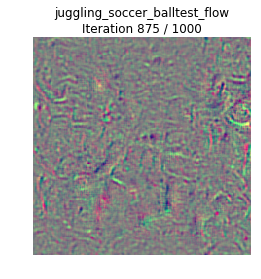

iteration: 875 1644.02321506


In [ ]:
"""
Run FLOW visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, action_name + "test", stream_type='flow', num_frames=25, num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, blur_every=10, max_jitter=32, sigma=.5)

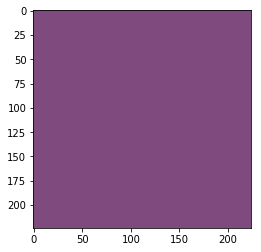

In [44]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
#print(index_to_class)

temp = np.append(0*np.ones((224, 224, 1)), -.205*np.ones((224, 224, 1)), axis=2)
plt.imshow(create_flow_image(temp))